# Reference systems

> **Goal**: Explain the reference systems used for crystal orientation in FTIR and EBSD

TODO

## FTIR reference system

To estimate the orientation of the crystals in the FTIR we will have to consider the following reference frames to establish a consistent coordinate frame:

- the microscope stage/sample pair
- the position of the reference transmittance envelope with respect to the reference system of the microscope
- the position of the crystalline elements (axes, planes, etc.) with respect to the transmitance envelope

We start by defining that all coordinate systems used will be right handed, which also implies the right hand rule for the sense of rotations (positive rotation counter-clockwise).

TODO: make figures

Let's build the transmittance envelope to see how it looks like and how to reference it to the microscope/sample coordinate system. For this, we will use the following equation from Asimow et al. (2006):

$$
T(\theta,\phi,\lambda) = T_a(\lambda)cos^2\theta sin^2\phi + T_b(\lambda)sin^2\theta sin^2\phi + T_c(\lambda)cos^2\phi
$$

where  
- $T_a$,  $T_b$,  $T_c$ are the transmission values along a, b and c-axis, respectively
- $\theta$ and $\phi$ are the polar coordinates of the vector $E$ relative to the a, b, and c-axis (figure X) representing the transmitance value for a particular direction
- $\lambda$ represents a specific wavelenght.

![Asimow](https://raw.githubusercontent.com/bertopadron/FTIR-EBSD/main/notebooks2learn/imgs/asimow_fig1.png)

We need to implement this equation and another one that converts polar coordinates to Cartesian coordinates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial.transform import Rotation as r

In [2]:
def sph2cart(phi, theta, T):
    """ Convert from spherical/polar (phi, thetha) to cartesian
    coordinates.

    Parameters
    ----------
    phi : int or float between 0 and pi/2
        angle respect to the c-axis in radians
    theta : int or float between 0 and 2*pi
        angle respect to the a-axis  in radians
    T : int or float
        the magnitud of the vector (rho) in polar coordinates

    Returns
    -------
    numpy ndarrays (1d)
        three numpy 1d arrays with the x, y, and z coordinates
    """
    
    x = T * np.sin(phi) * np.cos(theta)
    y = T * np.sin(phi) * np.sin(theta)
    z = T * np.cos(phi)
    
    return np.around(x, decimals=6), np.around(y, decimals=6), np.around(z, decimals=6)


def Tvalues(trans, phi, theta):
    """ Calculates the transmission value for any direction in polar
    coordinates using the equation (5) of Asimov et al. (2006) for a
    especific wavelength ignoring the sample thickness (i.e. =1).

    Parameters
    ----------
    trans : a tuple of size 3
        tuple containeing the transmission values along a-axis (Ta),
        b-axis (Tb), and c-axis (Tc). -> (Ta, Tb, Tc)
    phi : int or float between 0 and pi/2
        angle respect to the c-axis in radians
    theta : int or float between 0 and 2*pi
        angle respect to the a-axis in radians

    Returns
    -------
    numpy array
        the calculated T values for any given orientation
    """

    # extract Tx values
    Ta, Tb, Tc = trans
    
    return Ta * np.cos(theta)**2 * np.sin(phi)**2 + \
           Tb * np.sin(theta)**2 * np.sin(phi)**2 + \
           Tc * np.cos(phi)**2

[ 1.        0.707107  0.       -1.       -0.707107 -0.      ]
[ 0.707107  0.5       0.       -0.707107 -0.5      -0.      ]


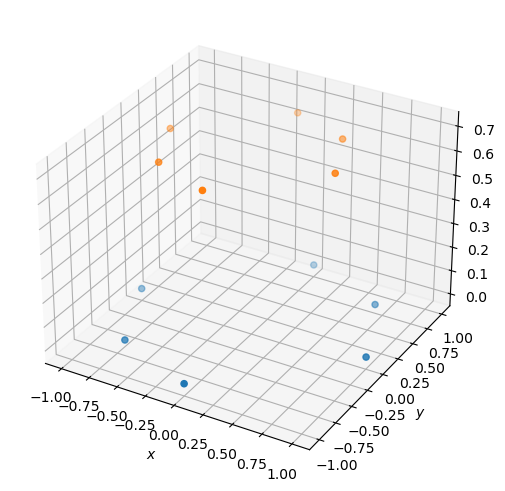

In [3]:
phi = np.deg2rad(np.array([90, 90, 90, 90, 90, 90]))
phi2 = np.deg2rad(np.array([45, 45, 45, 45, 45, 45]))
theta = np.deg2rad(np.array([0, 45, 90, 180, 225, 270]))
vals = np.array([1, 1, 1, 1, 1, 1])

x, y, z = sph2cart(phi, theta, vals)
x2, y2, z2 = sph2cart(phi2, theta, vals)
print(x)
print(x2)

# uncomment this to view figures interactively
#%matplotlib qt

# make figure
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)

ax.scatter(x, y, z)
ax.scatter(x2, y2, z2)
_ = ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

If $\phi=90$ then $z$ coordinates must be zero and all the point belong the $xy$ plane (blue points). $\theta$ indicates the angle respect to the $x$ axis and the third parameter indicate the magnitude of the vector (this is why when using $\theta = 45$ the $x$ coordinates are 0.71 not 1). When using a different $\phi$ value (e.g. $\phi=45$) all the points lines within a different plane with the same normal vector $(0,0,1)$ (i.e. parallel to the $xy$ plane) (orange points). In summary, in this reference frame $\theta$ is the angle respect to the $x$ axis, $\phi$ controls the $z$ value, and the third parameter how far are the point from the origin $(0,0,0)$ 

(Text(0.5, 0, '$x$'), Text(0.5, 0.5, '$y$'), Text(0.5, 0, '$z$'))

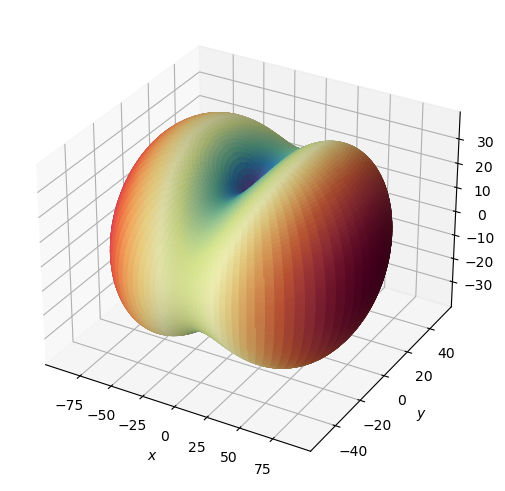

In [4]:
# generate spherical/polar coordinates
theta = np.linspace(0, 2*np.pi, 100)
phi = np.arccos(1 - 2 * np.linspace(0, 1, 100))  # phi = arcos(1 - 2x) in this case np.linspace goes from 0 to 1 (not pi)!*
phi, theta = np.meshgrid(phi, theta)
# *See https://mathworld.wolfram.com/SpherePointPicking.html or https://www.jasondavies.com/maps/random-points/

# estimate T values
T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

# convert from spherical to cartesian coordinates
x, y, z = sph2cart(phi, theta, T)

# normalize colors for T values to max and min values
Tmax, Tmin = T.max(), T.min()
Tcolors = (T - Tmin) / (Tmax - Tmin)

# make figure
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)

ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

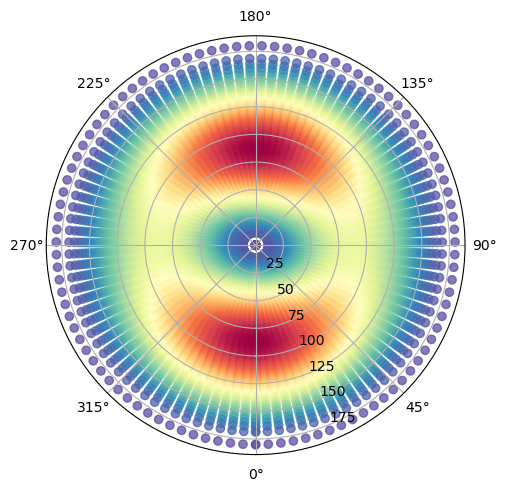

In [5]:
# make polar scatter figure, colors represent T values
# make figure
fig2, ax = plt.subplots(subplot_kw={"projection": "polar"}, constrained_layout=True)

# locate theta origin south as in the figure 1 of Asimov et al. (2006)
ax.set_theta_zero_location('S')

# plot the data (for phi I converted radians to degrees)
_ = ax.scatter(theta, np.rad2deg(phi), c=T, cmap='Spectral_r', alpha=0.75)

Suppose that the reference transmittance envelope is one that corresponds to a triplet of Euler angles [0, 0, 0]...

TODO

## EBSD reference system

> See https://doi.org/10.1016/j.matchar.2016.04.008 for details

TODO

![EBSD_unit_cell_convention](https://raw.githubusercontent.com/bertopadron/FTIR-EBSD/main/notebooks2learn/imgs/EBSD_ref_frame.png)

To determine the full orientation of a crystal, it is also necessary to define a Cartesian reference frame for the crystal lattice. The unit cell is commonly described using three lengths, $a$, $b$ and $c$ and three angles $α$, $β$, $γ$, $α$ describing the angle between the $b$ and $c$ axes, $β$ between $c$ and $a$, and $γ$ between $a$ and $b$ (Fig X). The reference crystal lattice can be oriented arbitrarily in the Cartesian reference system, most EBSD vendors assume the following convention (for a general case):

- $a$, $b$ and $c$ form a right handed set.
- $c$ is parallel to the $z_c$ axis.
- $b$ lies in the $y_c$-$z_c$ plane, at an angle $α$ to $c$
- $a$ is pointed such that it is an angle $β$ to $c$ and $γ$ to $b$


![EBSD_ref_frame](https://raw.githubusercontent.com/bertopadron/FTIR-EBSD/main/notebooks2learn/imgs/EBSD_unit_cell_convention.png)

In [6]:
import sys
import scipy as sp
from datetime import date    
today = date.today().isoformat()

print(f'Notebook tested in {today} using:')
print('Python', sys.version)
print('Numpy', np.__version__)
print('Scipy', sp.__version__)

Notebook tested in 2023-03-03 using:
Python 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
Numpy 1.23.5
Scipy 1.10.0
